In [22]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from torch.optim import AdamW
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence

# Emotion to integer mapping for the CREMA-D dataset
emotion_map = {
    "ANG": 0,  # Anger
    "DIS": 1,  # Disgust
    "FEA": 2,  # Fear
    "HAP": 3,  # Happy
    "NEU": 4,  # Neutral
    "SAD": 5,  # Sad
}

class CREMADataset(Dataset):
    def __init__(self, audio_dir, processor, emotion_map, file_paths=None, labels=None, sample_rate=16000):
        self.audio_dir = audio_dir
        self.processor = processor
        self.emotion_map = emotion_map
        self.sample_rate = sample_rate
        self.file_paths = []
        self.labels = []

        if file_paths is not None and labels is not None:
            self.file_paths = file_paths
            self.labels = labels
        else:
            for file_name in os.listdir(audio_dir):
                if file_name.endswith(".wav"):
                    parts = file_name.split('_')
                    if len(parts) < 3:
                        continue
                    emotion = parts[2]
                    label = self.emotion_map.get(emotion, -1)
                    if label != -1:
                        self.file_paths.append(os.path.join(audio_dir, file_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        
        # Load audio file
        waveform, sr = torchaudio.load(file_path)
        
        # Resample if necessary
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)
        
        # Use Wav2Vec2 processor to get features
        # inputs = self.processor(waveform.squeeze(0).numpy(), sampling_rate=self.sample_rate, return_tensors="pt", padding=True, truncation=True)
        inputs = processor(waveform.squeeze(0).numpy(), sampling_rate=self.sample_rate, return_tensors="pt", padding=True, truncation=True, max_length=16000)


        input_values = inputs['input_values'].squeeze(0)  # Remove batch dimension
        attention_mask = inputs['attention_mask'].squeeze(0)

        return {
            'input_values': input_values,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

from transformers import AutoProcessor
from transformers import Wav2Vec2FeatureExtractor

# Initialize the processor (which includes tokenizer and feature extractor)
# processor = Wav2Vec2Processor.from_pretrained("superb/wav2vec2-base-superb-er")
# processor = AutoProcessor.from_pretrained("superb/wav2vec2-base-superb-er")
processor = Wav2Vec2FeatureExtractor.from_pretrained("superb/wav2vec2-base-superb-er")


# Set max_length (choose a value based on your data)
max_length = 16000  # Modify this based on your dataset

# Tokenization step (add truncation and padding)
def tokenize_function(batch):
    # Tokenizing the audio input
    audio = batch["input_values"]
    return processor(audio, sampling_rate=16000, padding=True, truncation=True, max_length=max_length)

# Create dataset instance
audio_dir = "audio-emotion-dataset2"
dataset = CREMADataset(audio_dir=audio_dir, processor=processor, emotion_map=emotion_map)

# Split file paths and labels
train_file_paths, val_file_paths, train_labels, val_labels = train_test_split(
    dataset.file_paths, dataset.labels, test_size=0.2, random_state=42
)

# Create separate datasets
train_dataset = CREMADataset(audio_dir, processor, emotion_map, train_file_paths, train_labels)
val_dataset = CREMADataset(audio_dir, processor, emotion_map, val_file_paths, val_labels)

# Create DataLoaders for each
def collate_fn(batch):
    # Extract lists for input_values, attention_mask, and labels
    input_values = [item['input_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    # Pad input sequences to the same length
    input_values = pad_sequence(input_values, batch_first=True, padding_value=0)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    
    # Stack labels as they are integers and don't need padding
    labels = torch.stack(labels, dim=0)
    
    return {
        'input_values': input_values,
        'attention_mask': attention_mask,
        'labels': labels
    }

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [23]:
from collections import Counter

label_counts = Counter(train_labels + val_labels)  # or test_labels if available
print(label_counts)


Counter({1: 1271, 3: 1271, 2: 1271, 0: 1271, 5: 1270, 4: 1087})


In [24]:
from transformers import Wav2Vec2ForSequenceClassification

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "superb/wav2vec2-base-superb-er",  # Pretrained for Emotion Recognition!
    num_labels=len(emotion_map),
    ignore_mismatched_sizes=True  # Needed because we re-specify `num_labels`
)
model.freeze_feature_encoder()

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10

from transformers import get_scheduler
num_training_steps = epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=num_training_steps
)

from torch.nn import CrossEntropyLoss

# Count labels
label_counts = torch.tensor([1271, 1271, 1271, 1271, 1087, 1270], dtype=torch.float)
class_weights = 1.0 / label_counts
class_weights = class_weights / class_weights.sum() * len(class_weights)

loss_fn = CrossEntropyLoss(weight=class_weights.to(device))


# Initialize variables to track the best model
best_val_accuracy = 0.0  # You can also track best_val_loss if you prefer
best_model_path = "wav2vec2_emotion_classifier_best"

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
        batch = {key: value.to(device) for key, value in batch.items()}
        inputs = batch['input_values']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        
        optimizer.zero_grad()
        
        outputs = model(input_values=inputs, attention_mask=attention_mask)
        logits = outputs.logits
        
        loss = loss_fn(logits, labels)  # ✅ Use custom loss
        
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=-1)
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)
    
    train_accuracy = correct_preds / total_preds
    avg_train_loss = total_loss / len(train_loader)
    
    print(f"Train Loss: {avg_train_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")
    
    # Validation loop
    model.eval()
    val_loss = 0
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation"):
            batch = {key: value.to(device) for key, value in batch.items()}
            inputs = batch['input_values']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            
            outputs = model(input_values=inputs, attention_mask=attention_mask)
            logits = outputs.logits
            
            loss = loss_fn(logits, labels)  # ✅ Use custom loss here too
            
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
    
    val_accuracy = correct_preds / total_preds
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}")
    
    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        model.save_pretrained(best_model_path)
        processor.save_pretrained(best_model_path)
        print(f"Saved the best model at epoch {epoch+1}.")



Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at superb/wav2vec2-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Training: 100%|██████████| 744/744 [02:43<00:00,  4.55it/s]


Train Loss: 1.6691 - Train Accuracy: 0.2986


Epoch 1 - Validation: 100%|██████████| 187/187 [00:07<00:00, 24.91it/s]


Validation Loss: 1.4678 - Validation Accuracy: 0.3794
Saved the best model at epoch 1.


Epoch 2 - Training: 100%|██████████| 744/744 [02:06<00:00,  5.90it/s]


Train Loss: 1.4128 - Train Accuracy: 0.4244


Epoch 2 - Validation: 100%|██████████| 187/187 [00:08<00:00, 22.41it/s]


Validation Loss: 1.3938 - Validation Accuracy: 0.4345
Saved the best model at epoch 2.


Epoch 3 - Training: 100%|██████████| 744/744 [02:12<00:00,  5.62it/s]


Train Loss: 1.3272 - Train Accuracy: 0.4664


Epoch 3 - Validation: 100%|██████████| 187/187 [00:08<00:00, 21.35it/s]


Validation Loss: 1.3041 - Validation Accuracy: 0.4688
Saved the best model at epoch 3.


Epoch 4 - Training: 100%|██████████| 744/744 [02:15<00:00,  5.48it/s]


Train Loss: 1.2706 - Train Accuracy: 0.5010


Epoch 4 - Validation: 100%|██████████| 187/187 [00:09<00:00, 20.31it/s]


Validation Loss: 1.2380 - Validation Accuracy: 0.5118
Saved the best model at epoch 4.


Epoch 5 - Training: 100%|██████████| 744/744 [02:18<00:00,  5.37it/s]


Train Loss: 1.2111 - Train Accuracy: 0.5185


Epoch 5 - Validation: 100%|██████████| 187/187 [00:09<00:00, 20.23it/s]


Validation Loss: 1.2667 - Validation Accuracy: 0.5024


Epoch 6 - Training: 100%|██████████| 744/744 [02:18<00:00,  5.37it/s]


Train Loss: 1.1649 - Train Accuracy: 0.5472


Epoch 6 - Validation: 100%|██████████| 187/187 [00:09<00:00, 20.34it/s]


Validation Loss: 1.2442 - Validation Accuracy: 0.5104


Epoch 7 - Training: 100%|██████████| 744/744 [02:19<00:00,  5.34it/s]


Train Loss: 1.1278 - Train Accuracy: 0.5571


Epoch 7 - Validation: 100%|██████████| 187/187 [00:09<00:00, 20.10it/s]


Validation Loss: 1.2124 - Validation Accuracy: 0.5198
Saved the best model at epoch 7.


Epoch 8 - Training: 100%|██████████| 744/744 [02:20<00:00,  5.31it/s]


Train Loss: 1.0946 - Train Accuracy: 0.5691


Epoch 8 - Validation: 100%|██████████| 187/187 [00:09<00:00, 20.15it/s]


Validation Loss: 1.1869 - Validation Accuracy: 0.5373
Saved the best model at epoch 8.


Epoch 9 - Training: 100%|██████████| 744/744 [02:20<00:00,  5.31it/s]


Train Loss: 1.0581 - Train Accuracy: 0.5936


Epoch 9 - Validation: 100%|██████████| 187/187 [00:09<00:00, 20.13it/s]


Validation Loss: 1.1774 - Validation Accuracy: 0.5507
Saved the best model at epoch 9.


Epoch 10 - Training: 100%|██████████| 744/744 [02:20<00:00,  5.30it/s]


Train Loss: 1.0511 - Train Accuracy: 0.5946


Epoch 10 - Validation: 100%|██████████| 187/187 [00:09<00:00, 19.99it/s]


Validation Loss: 1.1660 - Validation Accuracy: 0.5514
Saved the best model at epoch 10.


In [25]:
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor
# model_path = "wav2vec2_emotion_classifier"

# Load model and processor
model = Wav2Vec2ForSequenceClassification.from_pretrained(best_model_path)
# processor = Wav2Vec2Processor.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Send model to GPU or CPU as needed
model.eval()

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
from sklearn.metrics import accuracy_score

# Inference loop
true_labels = []
pred_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_values = batch['input_values'].to(device)
        attention_mask = batch.get('attention_mask')
        if attention_mask is not None:
            attention_mask = attention_mask.to(device)

        labels = batch['labels'].to(device)

        outputs = model(input_values, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predictions.cpu().numpy())

# Accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
# best  Validation Accuracy: 55.14%

Validation Accuracy: 55.14%


In [28]:
from sklearn.metrics import f1_score

val_f1 = f1_score(true_labels, pred_labels, average="weighted")
val_f1

0.5390588551657565

In [29]:
labels = [label for label, idx in sorted(emotion_map.items(), key=lambda x: x[1])]

from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_labels, target_names=labels))

              precision    recall  f1-score   support

         ANG       0.66      0.80      0.73       237
         DIS       0.45      0.28      0.34       268
         FEA       0.56      0.45      0.50       246
         HAP       0.60      0.52      0.55       259
         NEU       0.53      0.74      0.62       210
         SAD       0.49      0.58      0.53       269

    accuracy                           0.55      1489
   macro avg       0.55      0.56      0.54      1489
weighted avg       0.54      0.55      0.54      1489



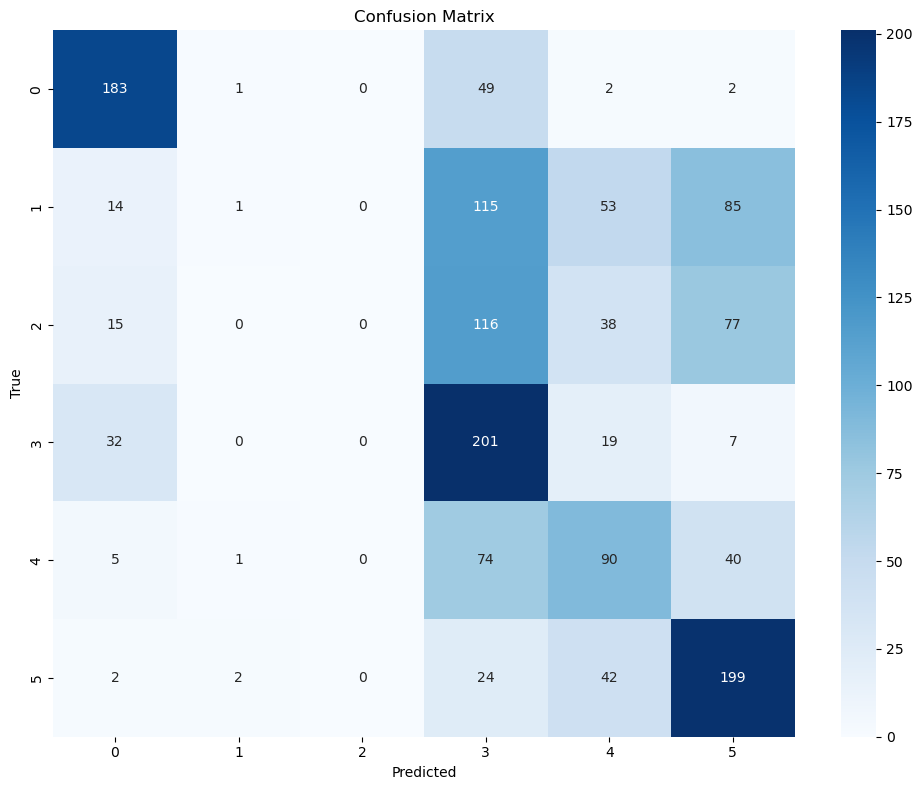

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
labels = list(emotion_map.values())  # Ensure this matches the order in your label encoding

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()